In [1]:
#!python -m pip install git+https://github.com/aliechoes/iflai.git

In [2]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
# from iflai.ml.feature_selection import AutoFeatureSelection
# from iflai.utils import list_of_dict_to_dict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.utils import shuffle
import skimage
plt.ion()   # interactive mode
from skimage.transform import   rescale, resize 
#from imageio import imread
import random
#import umap
from tqdm import tqdm
from random import sample
from skimage.transform import resize
import h5py
from skimage.exposure import rescale_intensity
import seaborn as sns

In [3]:


# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [4]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.dummy import DummyClassifier

def classification_complete_report(estimator, X, y_true, labels = None ,plot = True ): 
    y_pred = estimator.predict(X)
    y_pred_dummy = DummyClassifier().fit(X,y_true).predict(X)
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("No information rate: %.2f" % accuracy_score(y_true, y_pred_dummy) )
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true, labels = labels ,cmap = "Greys", xticks_rotation='vertical')
    

In [5]:
def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

In [6]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset.csv.gz")
metadata


,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1
...,...,...,...,...,...,...,...
1065962,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,72493,unlabeled,-1
1065963,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,106656,unlabeled,-1
1065964,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,110990,unlabeled,-1
1065965,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,71451,unlabeled,-1


In [7]:
indx = metadata.donor == "Donor_10"

metadata.loc[indx,"donor"] = "Donor_2"

In [8]:

df_features = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/df_features_subset.csv.gz")
df_features

,mask_based_area_BF,mask_based_bbox_area_BF,mask_based_convex_area_BF,mask_based_eccentricity_BF,mask_based_equivalent_diameter_BF,mask_based_euler_number_BF,mask_based_extent_BF,mask_based_feret_diameter_max_BF,mask_based_filled_area_BF,mask_based_major_axis_length_BF,...,max_intensity_ratio_MHCII_R7_R8,sum_intensity_ratio_CD3_R7_R8,mean_intensity_ratio_CD3_R7_R8,max_intensity_ratio_CD3_R7_R8,sum_intensity_ratio_P-CD3zeta_R7_R8,mean_intensity_ratio_P-CD3zeta_R7_R8,max_intensity_ratio_P-CD3zeta_R7_R8,sum_intensity_ratio_Live-Dead_R7_R8,mean_intensity_ratio_Live-Dead_R7_R8,max_intensity_ratio_Live-Dead_R7_R8
0,2228,3021,2392,0.484394,53.261409,1,0.737504,61.717096,2228,57.336477,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,885,1155,925,0.238094,33.568095,1,0.766234,36.138622,885,34.216438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,656,812,689,0.369856,28.900608,1,0.807882,32.756679,656,30.262314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,753,899,780,0.386491,30.963678,1,0.837597,34.132096,753,32.348559,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1208,1512,1247,0.661747,39.218279,1,0.798942,51.224994,1208,45.782110,...,19.735296,0.465222,0.465222,25.504583,0.481531,0.481531,26.397369,0.754085,0.754085,45.835530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065962,973,1190,997,0.100885,35.197473,1,0.817647,37.215588,973,35.332773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1065963,3956,5046,4180,0.787555,70.971372,1,0.783987,91.760558,3956,91.437834,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1065964,909,1073,928,0.622298,34.020211,1,0.847158,40.804412,909,38.830446,...,5.716450,0.190820,0.190820,7.474995,0.115499,0.115499,4.191402,1.000000,1.000000,32.928658
1065965,3388,4272,3670,0.875994,65.679035,1,0.793071,90.426766,3388,96.830707,...,6.247939,0.039196,0.039196,124.378412,0.045108,0.045108,140.202637,0.005466,0.005466,16.385927


In [9]:
classification_indx = ~df_features.columns.str.contains( "Antibody") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "Live-Dead") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "CD18")  
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R2")  
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R3")  
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R8")  
classification_indx = classification_indx& ~df_features.columns.str.contains( "background") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "moment") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "percent") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "mask_based_mean") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "mask_based_min") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "mask_based_max")  
classification_indx = classification_indx& ~df_features.columns.str.contains( "RMS") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "intensity_BF") 
#classification_indx = classification_indx& ~df_features.columns.str.contains( "distance_BF") 
#classification_indx = classification_indx& ~df_features.columns.str.contains( "contrast_BF") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R1_R2") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R1_R3") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R1_R4") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R1_R5") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R1_R6") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R1_R7") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R1_R8") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R2_R1") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R2_R3") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R2_R4") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R2_R5") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R2_R6") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R2_R7") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R2_R8") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R3_R1") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R3_R2") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R3_R4") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R3_R5") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R3_R6") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R3_R7") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R3_R8") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R4_R1") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R4_R2") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R4_R3") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R4_R5") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R4_R6") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R4_R7") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R4_R8") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R5_R1") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R5_R2") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R5_R3") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R5_R4") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R5_R8") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R6_R1") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R6_R2") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R6_R3") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R6_R4") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R6_R5") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R6_R7") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R6_R8") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R7_R1") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R7_R2") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R7_R3") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R7_R4") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R7_R5") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R7_R6") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R7_R8") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R8_R1") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R8_R2") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R8_R3") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R8_R4") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R8_R5") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R8_R6") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R8_R7") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "cell_distance")

In [10]:
channels = {
     "Ch1": ("Greys", "BF"),  #R1
     "Ch2": ("Greens", "Antibody"),  #R2
     "Ch3": ("Reds", "CD18"),  #R3
     "Ch4": ("Oranges", "F-Actin"),  #R4
     "Ch6": ("RdPu", "MHCII"),  #R5
     "Ch7": ("Purples", "CD3/CD4"),  #R6
     "Ch11": ("Blues", "P-CD3zeta"),  #R7
     "Ch12": ("Greens", "Live-Dead")  #R8
 }

## finding optimal top_k

In [11]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets'] 



labeled_index = metadata["label"].isin(set_of_interesting_classes)
labeled_index = labeled_index & metadata["condition"].isin(["-SEA","+SEA"])
labeled_index = labeled_index[labeled_index].index.tolist()


In [12]:
from sklearn import manifold, datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
 
indx = metadata.set.isin([ "train", "validation","test" ])
indx = indx & metadata.label.isin(set_of_interesting_classes)



In [13]:
train_index = metadata["set"] == "train"
train_index = train_index & metadata.label.isin(set_of_interesting_classes)
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & metadata.label.isin(set_of_interesting_classes)
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & metadata.label.isin(set_of_interesting_classes)
test_index = test_index[test_index].index

In [14]:
from sklearn.metrics import f1_score
#range(5,150)

I avoided the the next part as it takes crazy amount of time

In [ ]:
list_of_k = list(reversed(range(1,classification_indx.sum(),5)))

In [ ]:
from tqdm import tqdm
from xgboost import XGBClassifier

f1_macro_validation = []
for k in tqdm(list_of_k):
    xgb = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelection( top_k = k )),
                 ('xgb', XGBClassifier(n_jobs = -1, 
                                       n_estimators = 100, 
                                       eval_metric = "logloss") )
        ], verbose=False)

    xgb.fit(df_features.loc[train_index.tolist() , classification_indx],  
               metadata.loc[train_index.tolist()  , "label"] )
        
    f1_macro_validation.append(f1_score(metadata.loc[validation_index.tolist(), "label"],
        xgb.predict(df_features.loc[validation_index.tolist(), 
                                    classification_indx]), average='macro'))
    

In [ ]:
np.array(f1_macro_validation).argmax(),round( np.array(f1_macro_validation).max(),2)

In [ ]:
np.array(list_of_k)[22]

In [ ]:


fig, ax = plt.subplots(figsize=(10,4))

ax = sns.lineplot(x = list_of_k,
                 y = f1_macro_validation,
                 color = "grey")  

ax.set_ylim(0.2,1.0)
ax.axvline(136, 0.90,0.98,color = "k", ls = "--")

plt.savefig('3 - top_k.png', bbox_inches="tight")
plt.savefig('3 - top_k.svg', bbox_inches="tight")

we got 136 as the best top__k

In [ ]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

xgb = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelection( top_k = 136 ,
                                                              verbose=True)),
                 ('xgb', XGBClassifier(n_jobs = -1, 
                                       n_estimators = 100, 
                                       eval_metric = "logloss") )
        ], verbose=True)

xgb.fit(df_features.loc[train_index.tolist() + validation_index.tolist() , classification_indx],  
               metadata.loc[train_index.tolist() + validation_index.tolist() , "label"] )

In [ ]:
sns.set(font_scale = 1.0)
sns.set_style("ticks")
classification_complete_report(xgb, 
                               df_features.loc[test_index, classification_indx],
                               metadata.loc[test_index, "label"], labels = set_of_interesting_classes)

#plt.savefig('Figure 1/classification_results_df_features.png', bbox_inches="tight")

# Feature importance

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

feature_importance = pd.DataFrame(columns=df_features.columns[classification_indx])

rskf = RepeatedStratifiedKFold(n_splits=5, 
                               n_repeats=20,
                               random_state=0)

indx =  train_index.tolist() + validation_index.tolist()

for index_stratified, _ in tqdm(rskf.split(indx, metadata.loc[indx, "label"]), 
                                total=rskf.cvargs["n_splits"] * rskf.n_repeats):
    xgb = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelection( top_k = np.random.randint(30,200) ,
                                                                            verbose=False)),
                 ('xgb', XGBClassifier(n_jobs = -1, 
                                       n_estimators = 100, 
                                       eval_metric = "logloss") )
        ], verbose=False)

    xgb.fit(df_features.loc[index_stratified , classification_indx],  
                   metadata.loc[index_stratified, "label"] )
    
    selected_features = xgb.steps[1][1].selected_features
    selected_feature_names = df_features.columns[classification_indx][selected_features]
    feature_importance_dummy = pd.DataFrame(xgb.steps[2][1].feature_importances_.reshape(1,len(selected_features)), 
                                            columns=selected_feature_names)
    feature_importance = feature_importance.append(feature_importance_dummy, ignore_index=True)
    feature_importance_dummy = None

In [ ]:
feature_importance = feature_importance.fillna(0.)

In [ ]:
feature_importance

In [ ]:
pd.melt(feature_importance)

In [ ]:
fig, ax = plt.subplots(1, figsize = (8,4))
 
sorted_median = feature_importance.median(0).sort_values(ascending=False).index.tolist()[:10]

ax = sns.barplot(y="value", 
                 x="variable", 
                 data=pd.melt(feature_importance), 
                 palette=["Grey"] ,
                 estimator = np.median,
                 order = sorted_median,  
                 ax = ax) 
 
ax.set_xticklabels(sorted_median, rotation = "vertical")
#ax.set_ylim(0.3,1.0)

plt.savefig('3 - feature importance gini-index.png', bbox_inches="tight")
plt.savefig('3 - feature importance gini-index.svg', bbox_inches="tight")

In [ ]:
sorted_median

In [ ]:
metadata.head()

In [ ]:
from skimage.util import crop
from skimage.exposure import rescale_intensity
# BF, CD18, F-Actin, MHCII, CD3, P-CD3zeta Greens, 
channels_cmap = ["Greys", "Oranges","Blues","Greens", "Reds"]
nrows = 10
ncols = 3
image_size = 128
channels =[0,3,4,5,6]
percentiles = (0.05,0.50,0.95)

figsize = (ncols,nrows)
plt.rcParams["axes.grid"] = False
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for i  in range(nrows) : 
    ax[i,0].set_ylabel("")
    
for j  in range(ncols) : 
    ax[0,j].set_xlabel("")   


#  correlation_distance_R5_MHCII_R6_CD3 
################################################################
col = "correlation_distance_R5_MHCII_R6_CD3"    
indx = metadata["experiment"].isin(["Experiment_4"]) 
indx = indx & metadata["condition"].isin(["+SEA"]) 
indx = indx & metadata["set"].isin(["train"]) 

files = []
i = 0
for q in percentiles:
    sample_index = (df_features.loc[indx,col]-df_features.loc[indx,col].quantile(q)).abs().sort_values().index[0]
    files.append(metadata.loc[sample_index,"file"])
    
channels_to_be_plotted = [0,5,4]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if k>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = np.zeros((image_size, image_size , len(channels_to_be_plotted)))
    for k,ch in enumerate(channels_to_be_plotted):
        image_dummy_ch = crop(image[:,:,k], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy_ch = np.pad(image_dummy_ch, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
        image_dummy[:,:,k] = rescale_intensity(image_dummy_ch, in_range = (vmin[k], vmax[k]), out_range = (0.,1.))
    
    image_dummy[:,:,0] = 0.
    image_dummy = image_dummy / image_dummy.max()
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25),:] =  1.
    
    ax[i,j].imshow( image_dummy)
    data.close()




    
################################################################
col = "sum_intensity_ratio_MHCII_R5_R6"   
indx = metadata["experiment"].isin(["Experiment_4"]) 
indx = indx & metadata["condition"].isin(["+SEA"]) 
indx = indx & metadata["set"].isin(["train"]) 

files = []
i = 1
for q in percentiles:
    sample_index = (df_features.loc[indx,col]-df_features.loc[indx,col].quantile(q)).abs().sort_values().index[0]
    files.append(metadata.loc[sample_index,"file"])
    
vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [4]
for j, f in enumerate(files):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        if j>0:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.60)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 0.995)  )
        else:
            vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.0)  )
            vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    #image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Blues", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
################################################################
col = 'kurtosis_intensity_P-CD3zeta'   
indx = metadata["experiment"].isin(["Experiment_4"]) 
indx = indx & metadata["condition"].isin(["+SEA"]) 
indx = indx & metadata["set"].isin(["train"]) 

files = []
i = 2
for q in percentiles:
    sample_index = (df_features.loc[indx,col]-df_features.loc[indx,col].quantile(q)).abs().sort_values().index[0]
    files.append(metadata.loc[sample_index,"file"])
    
vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [6]
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.50)  )
        vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 0.999)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    #image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Reds", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
    
################################################################
col = 'skew_intensity_P-CD3zeta'
indx = metadata["experiment"].isin(["Experiment_4"]) 
indx = indx & metadata["condition"].isin(["+SEA"]) 
indx = indx & metadata["set"].isin(["train"]) 

files = []
i = 3
for q in percentiles:
    sample_index = (df_features.loc[indx,col]-df_features.loc[indx,col].quantile(q)).abs().sort_values().index[0]
    files.append(metadata.loc[sample_index,"file"])
    
vmin = [4095.]
vmax = [0.]
channels_to_be_plotted = [6]
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.50)  )
        vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 0.999)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    #image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Reds", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
    
################################################################
col = 'mask_based_equivalent_diameter_BF'
indx = metadata["experiment"].isin(["Experiment_4"]) 
indx = indx & metadata["condition"].isin(["+SEA"]) 
indx = indx & metadata["set"].isin(["train"]) 

files = []
i = 4
for q in percentiles:
    sample_index = (df_features.loc[indx,col]-df_features.loc[indx,col].quantile(q)).abs().sort_values().index[0]
    files.append(metadata.loc[sample_index,"file"])
    
channels_to_be_plotted = [0]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.0)  )
        vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 1.0)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    #image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Greys", vmin = vmin[0], vmax = vmax[0] )
    data.close()

################################################################
col = 'contrast_MHCII'
indx = metadata["experiment"].isin(["Experiment_4"]) 
indx = indx & metadata["condition"].isin(["+SEA"]) 
indx = indx & metadata["set"].isin(["train"]) 

files = []
i = 5
for q in percentiles:
    sample_index = (df_features.loc[indx,col]-df_features.loc[indx,col].quantile(q)).abs().sort_values().index[0]
    files.append(metadata.loc[sample_index,"file"])
    
channels_to_be_plotted = [4]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.50)  )
        vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 0.999)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    #image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Blues", vmin = vmin[0], vmax = vmax[0] )
    data.close()

################################################################
col = 'correlation_P-CD3zeta'
indx = metadata["experiment"].isin(["Experiment_4"]) 
indx = indx & metadata["condition"].isin(["+SEA"]) 
indx = indx & metadata["set"].isin(["train"]) 

files = []
i = 6
for q in percentiles:
    sample_index = (df_features.loc[indx,col]-df_features.loc[indx,col].quantile(q)).abs().sort_values().index[0]
    files.append(metadata.loc[sample_index,"file"])
    
channels_to_be_plotted = [6]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.50)  )
        vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 0.999)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    #image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Reds", vmin = vmin[0], vmax = vmax[0] )
    data.close()

    

################################################################
col = 'correlation_CD3'
indx = metadata["experiment"].isin(["Experiment_4"]) 
indx = indx & metadata["condition"].isin(["+SEA"]) 
indx = indx & metadata["set"].isin(["train"]) 

files = []
i = 7
for q in percentiles:
    sample_index = (df_features.loc[indx,col]-df_features.loc[indx,col].quantile(q)).abs().sort_values().index[0]
    files.append(metadata.loc[sample_index,"file"])
    
channels_to_be_plotted = [5]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.50)  )
        vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 0.999)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    #image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Greens", vmin = vmin[0], vmax = vmax[0] )
    data.close()
        

################################################################
col = 'contrast_CD3'
indx = metadata["experiment"].isin(["Experiment_4"]) 
indx = indx & metadata["condition"].isin(["+SEA"]) 
indx = indx & metadata["set"].isin(["train"]) 

files = []
i = 8
for q in percentiles:
    sample_index = (df_features.loc[indx,col]-df_features.loc[indx,col].quantile(q)).abs().sort_values().index[0]
    files.append(metadata.loc[sample_index,"file"])
    
channels_to_be_plotted = [5]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.50)  )
        vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 0.999)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = crop(image[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,0], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )

    #image_dummy = image_dummy*mask_dummy
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] =  vmax[0]
    
    ax[i,j].imshow( image_dummy, cmap = "Greens", vmin = vmin[0], vmax = vmax[0] )
    data.close()
    
    

################################################################
col = 'manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta'   
indx = metadata["experiment"].isin(["Experiment_4"]) 
indx = indx & metadata["condition"].isin(["+SEA"]) 
indx = indx & metadata["set"].isin(["train"]) 

files = []
i = 9
for q in percentiles:
    sample_index = (df_features.loc[indx,col]-df_features.loc[indx,col].quantile(q)).abs().sort_values().index[0]
    files.append(metadata.loc[sample_index,"file"])
    
channels_to_be_plotted = [6,0,4]
vmin = [4095.]*len(channels_to_be_plotted)
vmax = [0.]*len(channels_to_be_plotted)
for j in range(ncols):
    h5_file_ = h5py.File(files[j], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for k, ch in enumerate(channels_to_be_plotted):
        vmin[k] = min(vmin[k], np.quantile(image[:,:,ch], 0.60)  )
        vmax[k] = max(vmax[k], np.quantile(image[:,:,ch], 0.995)  )
            
for j, f in enumerate(files):
    data = h5py.File(f, "r"  )
    image = data.get("image")[()][:,:,channels_to_be_plotted]
    mask = data.get("mask")[()][:,:,channels_to_be_plotted]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    ax[i,j].axis('off')
    
    image_dummy = np.zeros((image_size, image_size , len(channels_to_be_plotted)))
    for k,ch in enumerate(channels_to_be_plotted):
        image_dummy_ch = crop(image[:,:,k], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
        image_dummy_ch = np.pad(image_dummy_ch, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
        image_dummy[:,:,k] = rescale_intensity(image_dummy_ch, in_range = (vmin[k], vmax[k]), out_range = (0.,1.))
    
    image_dummy[:,:,1] = 0.
    image_dummy = image_dummy / image_dummy.max()
    
    image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25),:] =  1.
    
    ax[i,j].imshow( image_dummy)
    data.close()




plt.savefig('1 - sample images based on the features.svg', bbox_inches="tight")

In [ ]:
[0,3,4,5,6]

In [ ]:
['correlation_distance_R5_MHCII_R6_CD3',
 'sum_intensity_ratio_MHCII_R5_R6',
 'kurtosis_intensity_P-CD3zeta',
 'skew_intensity_P-CD3zeta',
 'mask_based_equivalent_diameter_BF',
 'contrast_MHCII',
 'correlation_P-CD3zeta',
 'correlation_CD3',
 'contrast_CD3',
 'manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta']

In [ ]:
(df_features.loc[indx,col]-df_features.loc[indx,col].quantile(q)).abs().sort_values().index[0]

In [ ]:
new_index = metadata.file.isin(files)
df_features.loc[new_index, col]

In [ ]:

(df_features.loc[indx,col]-0.5).abs().argsort()[0:1]

In [ ]:

# B_cell 
object_number = 108
i = 0
data = h5py.File(experiment_path + str(object_number) + ".h5", "r"  )
image = data.get("image")[()][:,:,[0,3,4,5,6]]
mask = data.get("mask")[()][:,:,[0,3,4,5,6]]
h, w = crop_pad_h_w(image, image_size)
h1_crop, h2_crop, h1_pad, h2_pad =  h 
w1_crop, w2_crop, w1_pad, w2_pad = w 
for j in range(ncols):
    ax[i,j].axis('off')
    image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    image_dummy = np.pad(image_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.mean(image_dummy) )
    
    mask_dummy = crop(mask[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
    mask_dummy = np.pad(mask_dummy, ((h1_pad,h2_pad),(w1_pad,w2_pad)), 'constant', constant_values=np.min(mask_dummy) )
    
    if j ==0:
        image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] = image_dummy.max()
        ax[i,j].imshow( image_dummy, cmap = channels_cmap[j])      
    elif j in [1,2]:
        ax[i,j].imshow( image_dummy*mask_dummy, cmap = channels_cmap[j])    
    else:
        ax[i,j].imshow( image_dummy*0., cmap = channels_cmap[j]) 
data.close()      

In [ ]:
# TOP TEN FEATURES

In [ ]:
sorted_median

In [ ]:
selected_feature_names = feature_importance.median(0).sort_values(ascending=False).index.tolist()[:50]
selected_feature_names

In [ ]:
metadata

In [ ]:
indx = metadata.experiment == "Experiment_4"
indx = indx & (metadata.donor == "Donor_7")
indx = indx & (metadata.set == "train")

median_important_features = pd.concat([metadata.loc[indx,"label"],df_features.loc[indx,sorted_median]], axis = 1).groupby("label").median()
median_important_features.iloc[:,:] =StandardScaler().fit_transform(median_important_features)
median_important_features = median_important_features.loc[set_of_interesting_classes,:]
sns.clustermap(median_important_features, 
               cmap = "bwr", 
               col_cluster=True, 
               row_cluster=False)

In [ ]:
from sklearn import manifold, datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
 
indx = metadata.set.isin([ "train", "validation","test" ])
indx = indx & metadata.label.isin(set_of_interesting_classes)
method = manifold.TSNE(n_components=2)

X_transformed = method.fit_transform( StandardScaler().fit_transform( df_features.loc[indx,selected_feature_names] ) )

fig , ax = plt.subplots(1,2, figsize = (10,5) )

ax[0] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                     hue = metadata.loc[indx,"label"], 
                     s = 10, 
                     hue_order = set_of_interesting_classes, 
                     ax = ax[0] )  
ax[0].legend().remove()
ax[0].set_xticks([])
ax[0].set_yticks([])


X_transformed = method.fit_transform( StandardScaler().fit_transform( df_features.loc[indx,sorted_median] ) )

ax[1] = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                     hue = metadata.loc[indx,"label"], 
                     s = 10, 
                     hue_order = set_of_interesting_classes, 
                     ax = ax[1] )  
ax[1].legend().remove()
ax[1].set_xticks([])
ax[1].set_yticks([])


In [ ]:
# heatmap

In [15]:
df_features = df_features.loc[:,classification_indx]

## Channel importance

In [57]:
channels = ["_BF","_F-Actin","_CD3","_MHCII","_P-CD3zeta"]

In [58]:
from itertools import combinations

channel_combinations = sum([list(map(list, combinations(channels, i))) for i in range(len(channels) + 1)], [])
channel_combinations = channel_combinations[1:]
channel_combinations = [x for x in channel_combinations if "_BF" in x]

In [59]:
 
masks = ["_R1","_R4","_R5","_R6","_R7"]

In [60]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.preprocessing import LabelEncoder
from random import choices
le = LabelEncoder()

f1_values = []
num_samples = len(train_index.tolist() + validation_index.tolist())

for channels_to_include in tqdm(channel_combinations):
    f1_values_dummy = []
    for counter in range(5):
        print(counter, channels_to_include)

        channels_to_exculde = set(channels) - set(channels_to_include)
        channels_to_exculde = list(channels_to_exculde)

        col_index = df_features.columns.str.contains("No_Real_Value")

        for ch in channels_to_include:
            col_index = col_index + df_features.columns.str.contains(ch)

        for ch in channels_to_exculde:
            col_index = col_index & (~df_features.columns.str.contains(ch))
            R_num = channels.index(ch) 
            col_index = col_index & (~df_features.columns.str.contains(masks[R_num])) 


        xgb = XGBClassifier(n_jobs = 8, n_estimators = 100, 
                                           eval_metric = "logloss")

        subsample = choices(train_index.tolist() + validation_index.tolist(), k=num_samples)
        xgb.fit(df_features.loc[subsample, col_index], 
                 le.fit_transform(metadata.loc[subsample,"label"]) )

        preds = xgb.predict(df_features.loc[test_index.tolist(), col_index])
        
        f1_values_dummy.append(f1_score(le.fit_transform(metadata.loc[test_index,"label"]),
                        preds, average='macro'))
    f1_values.append(f1_values_dummy)

  0%|          | 0/16 [00:00<?, ?it/s]

0 ['_BF']
1 ['_BF']
2 ['_BF']
3 ['_BF']
4 ['_BF']


  6%|▋         | 1/16 [00:18<04:36, 18.46s/it]

0 ['_BF', '_F-Actin']
1 ['_BF', '_F-Actin']
2 ['_BF', '_F-Actin']
3 ['_BF', '_F-Actin']
4 ['_BF', '_F-Actin']


 12%|█▎        | 2/16 [00:42<05:08, 22.01s/it]

0 ['_BF', '_CD3']
1 ['_BF', '_CD3']
2 ['_BF', '_CD3']
3 ['_BF', '_CD3']
4 ['_BF', '_CD3']


 19%|█▉        | 3/16 [01:03<04:38, 21.46s/it]

0 ['_BF', '_MHCII']
1 ['_BF', '_MHCII']
2 ['_BF', '_MHCII']
3 ['_BF', '_MHCII']
4 ['_BF', '_MHCII']


 25%|██▌       | 4/16 [01:26<04:22, 21.86s/it]

0 ['_BF', '_P-CD3zeta']
1 ['_BF', '_P-CD3zeta']
2 ['_BF', '_P-CD3zeta']
3 ['_BF', '_P-CD3zeta']
4 ['_BF', '_P-CD3zeta']


 31%|███▏      | 5/16 [01:46<03:53, 21.24s/it]

0 ['_BF', '_F-Actin', '_CD3']
1 ['_BF', '_F-Actin', '_CD3']
2 ['_BF', '_F-Actin', '_CD3']
3 ['_BF', '_F-Actin', '_CD3']
4 ['_BF', '_F-Actin', '_CD3']


 38%|███▊      | 6/16 [02:10<03:40, 22.06s/it]

0 ['_BF', '_F-Actin', '_MHCII']
1 ['_BF', '_F-Actin', '_MHCII']
2 ['_BF', '_F-Actin', '_MHCII']
3 ['_BF', '_F-Actin', '_MHCII']
4 ['_BF', '_F-Actin', '_MHCII']


 44%|████▍     | 7/16 [02:34<03:26, 22.92s/it]

0 ['_BF', '_F-Actin', '_P-CD3zeta']
1 ['_BF', '_F-Actin', '_P-CD3zeta']
2 ['_BF', '_F-Actin', '_P-CD3zeta']
3 ['_BF', '_F-Actin', '_P-CD3zeta']
4 ['_BF', '_F-Actin', '_P-CD3zeta']


 50%|█████     | 8/16 [02:57<03:03, 22.91s/it]

0 ['_BF', '_CD3', '_MHCII']
1 ['_BF', '_CD3', '_MHCII']
2 ['_BF', '_CD3', '_MHCII']
3 ['_BF', '_CD3', '_MHCII']
4 ['_BF', '_CD3', '_MHCII']


 56%|█████▋    | 9/16 [03:19<02:38, 22.64s/it]

0 ['_BF', '_CD3', '_P-CD3zeta']
1 ['_BF', '_CD3', '_P-CD3zeta']
2 ['_BF', '_CD3', '_P-CD3zeta']
3 ['_BF', '_CD3', '_P-CD3zeta']
4 ['_BF', '_CD3', '_P-CD3zeta']


 62%|██████▎   | 10/16 [03:39<02:10, 21.82s/it]

0 ['_BF', '_MHCII', '_P-CD3zeta']
1 ['_BF', '_MHCII', '_P-CD3zeta']
2 ['_BF', '_MHCII', '_P-CD3zeta']
3 ['_BF', '_MHCII', '_P-CD3zeta']
4 ['_BF', '_MHCII', '_P-CD3zeta']


 69%|██████▉   | 11/16 [03:58<01:44, 20.86s/it]

0 ['_BF', '_F-Actin', '_CD3', '_MHCII']
1 ['_BF', '_F-Actin', '_CD3', '_MHCII']
2 ['_BF', '_F-Actin', '_CD3', '_MHCII']
3 ['_BF', '_F-Actin', '_CD3', '_MHCII']
4 ['_BF', '_F-Actin', '_CD3', '_MHCII']


 75%|███████▌  | 12/16 [04:25<01:30, 22.68s/it]

0 ['_BF', '_F-Actin', '_CD3', '_P-CD3zeta']
1 ['_BF', '_F-Actin', '_CD3', '_P-CD3zeta']
2 ['_BF', '_F-Actin', '_CD3', '_P-CD3zeta']
3 ['_BF', '_F-Actin', '_CD3', '_P-CD3zeta']
4 ['_BF', '_F-Actin', '_CD3', '_P-CD3zeta']


 81%|████████▏ | 13/16 [04:48<01:09, 23.02s/it]

0 ['_BF', '_F-Actin', '_MHCII', '_P-CD3zeta']
1 ['_BF', '_F-Actin', '_MHCII', '_P-CD3zeta']
2 ['_BF', '_F-Actin', '_MHCII', '_P-CD3zeta']
3 ['_BF', '_F-Actin', '_MHCII', '_P-CD3zeta']
4 ['_BF', '_F-Actin', '_MHCII', '_P-CD3zeta']


 88%|████████▊ | 14/16 [05:11<00:45, 22.76s/it]

0 ['_BF', '_CD3', '_MHCII', '_P-CD3zeta']
1 ['_BF', '_CD3', '_MHCII', '_P-CD3zeta']
2 ['_BF', '_CD3', '_MHCII', '_P-CD3zeta']
3 ['_BF', '_CD3', '_MHCII', '_P-CD3zeta']
4 ['_BF', '_CD3', '_MHCII', '_P-CD3zeta']


 94%|█████████▍| 15/16 [05:34<00:22, 23.00s/it]

0 ['_BF', '_F-Actin', '_CD3', '_MHCII', '_P-CD3zeta']
1 ['_BF', '_F-Actin', '_CD3', '_MHCII', '_P-CD3zeta']
2 ['_BF', '_F-Actin', '_CD3', '_MHCII', '_P-CD3zeta']
3 ['_BF', '_F-Actin', '_CD3', '_MHCII', '_P-CD3zeta']
4 ['_BF', '_F-Actin', '_CD3', '_MHCII', '_P-CD3zeta']


100%|██████████| 16/16 [06:04<00:00, 22.78s/it]


In [61]:
channel_combinations = pd.DataFrame(channel_combinations)

In [62]:

channel_combinations = channel_combinations.fillna("")

In [63]:
for i in range(channel_combinations.shape[0]):
    for j in range(channel_combinations.shape[1]):
        channel_combinations.iloc[i,j] = channel_combinations.iloc[i,j].replace("_","")

In [64]:
channel_combinations

,0,1,2,3,4
0,BF,,,,
1,BF,F-Actin,,,
2,BF,CD3,,,
3,BF,MHCII,,,
4,BF,P-CD3zeta,,,
5,BF,F-Actin,CD3,,
6,BF,F-Actin,MHCII,,
7,BF,F-Actin,P-CD3zeta,,
8,BF,CD3,MHCII,,
9,BF,CD3,P-CD3zeta,,


In [65]:
f1_index =  channel_combinations.iloc[:,0] + " + " + \
            channel_combinations.iloc[:,1] + " + " + \
            channel_combinations.iloc[:,2] + " + " + \
            channel_combinations.iloc[:,3] + " + " + \
            channel_combinations.iloc[:,4] 

In [66]:
pd.DataFrame(f1_values)

,0,1,2,3,4
0,0.589589,0.588580,0.582810,0.589670,0.593691
1,0.652608,0.654345,0.650834,0.654551,0.662254
2,0.687173,0.698059,0.705866,0.695355,0.683839
3,0.703551,0.683162,0.696029,0.693132,0.707072
4,0.815992,0.830778,0.819344,0.818520,0.817601
5,0.725854,0.703928,0.713854,0.712129,0.728776
6,0.740329,0.734355,0.720240,0.731366,0.733823
7,0.830383,0.831836,0.817520,0.827728,0.838881
8,0.785456,0.787200,0.774703,0.787160,0.784963
9,0.873014,0.870497,0.869702,0.864824,0.872321


In [67]:
f1_values = pd.DataFrame(f1_values)

In [68]:
f1_values["f1_index"] = f1_index

In [73]:
f1_values.std(1).sort_values(ascending=False).round(2)

5     0.01
3     0.01
2     0.01
11    0.01
7     0.01
6     0.01
10    0.01
4     0.01
8     0.01
15    0.00
13    0.00
1     0.00
0     0.00
14    0.00
9     0.00
12    0.00
dtype: float64

In [74]:
#f1_values = pd.melt(f1_values, id_vars=["f1_index"])

In [75]:
f1_values.mean(1).sort_values(ascending=False).round(2)

15    0.91
14    0.91
10    0.91
13    0.90
12    0.89
9     0.87
7     0.83
4     0.82
11    0.80
8     0.78
6     0.73
5     0.72
3     0.70
2     0.69
1     0.65
0     0.59
dtype: float64

15    0.91
14    0.91
10    0.91
13    0.90
12    0.89
9     0.87
7     0.83
4     0.82
11    0.80
8     0.78
6     0.73
5     0.72
3     0.70
2     0.69
1     0.65
0     0.59
dtype: float64


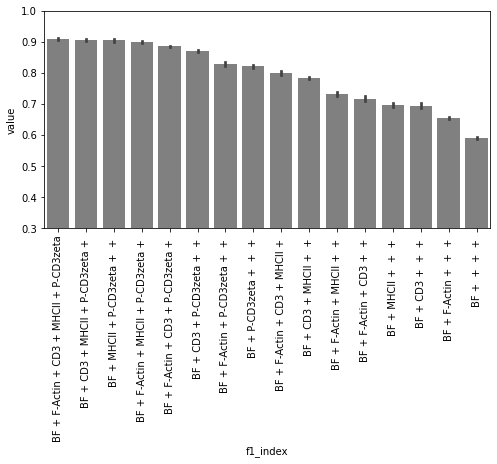

In [78]:
fig, ax = plt.subplots(1, figsize = (8,4))
 
sorted_mean = f1_values.mean(1).sort_values(ascending=False).index.tolist()

ax = sns.barplot(y="value", 
                 x="f1_index", 
                 data=pd.melt(f1_values, id_vars=["f1_index"]), 
                 palette=["Grey"] ,
                 estimator = np.mean,
                 order = f1_values.loc[sorted_mean, "f1_index"],  
                 ax = ax) 
 

print(f1_values.mean(1).sort_values(ascending=False).round(2))
ax.set_xticklabels(f1_values.loc[sorted_mean, "f1_index"], rotation = "vertical")
ax.set_ylim(0.3,1.0)

plt.savefig('Supplementary Figure - channel importance f1score.png', bbox_inches="tight")
plt.savefig('Supplementary Figure - channel importance f1score.svg', bbox_inches="tight")


## Predicting P-CD3zeta based on other features

In [ ]:
from sklearn.linear_model import Lasso, LassoCV, ElasticNet,ElasticNetCV, RidgeCV, Ridge, LassoLarsCV, LinearRegression,HuberRegressor, LassoLars
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression



In [ ]:
n_repeatition = 2
train_test_error = dict()
train_test_error["train_r2"] = []
train_test_error["test_r2"] = []
train_test_error["train_RMSE"] = []
train_test_error["test_RMSE"] = [] 
train_test_error["channel"] = [] 
train_test_error["correlation"] = [] 
preds_ = dict()
preds_["y_pred"] = []
preds_["y_test"] = []
preds_["channel"] = []

channels = ["_F-Actin","_MHCII","_CD3","_P-CD3zeta"]
for ch in channels:
    print(ch)
    reg_cols = (~df_features.columns.str.contains(ch))
    reg_cols = df_features.columns[reg_cols].copy()

    index_train_regression = metadata.set.isin(["train","validation"])

    index_test_regression = metadata.set.isin(["test"])

    X_train = df_features.loc[index_train_regression,reg_cols]
    y_train = df_features.loc[index_train_regression,"mean_intensity" +ch]
    
    reg_scaler = MinMaxScaler().fit(y_train.to_numpy().reshape(-1, 1))
    y_train = reg_scaler.transform(y_train.to_numpy().reshape(-1, 1))
    #y_train = np.log(y_train)

    X_test = df_features.loc[index_test_regression,reg_cols]
    y_test = df_features.loc[index_test_regression,"mean_intensity" +ch]
    y_test = reg_scaler.transform(y_test.to_numpy().reshape(-1, 1))
    #y_test = np.log(y_test)

    for _ in tqdm(range(n_repeatition)):


        regressor = Pipeline([
                        ('StandardScaler', StandardScaler()),  
                         ('feature_selection', SelectKBest(score_func=f_regression, k=np.random.randint(50,100))),
                         ('RandomForestRegressor', RandomForestRegressor( n_jobs = -1) )
        ], verbose=False)

        regressor.fit(X_train, y_train)
        preds_["y_test"] += y_test.reshape(-1).tolist()
        preds_["y_pred"] += regressor.predict(X_test).reshape(-1).tolist()  
        preds_["channel"] += [ch.split("_")[-1]]*len(y_test)

        train_test_error["train_r2"].append(r2_score(y_train, regressor.predict(X_train)))
        train_test_error["test_r2"].append(r2_score(y_test, regressor.predict(X_test)))

        train_test_error["train_RMSE"].append(mean_squared_error(y_train, regressor.predict(X_train), squared=False))
        train_test_error["test_RMSE"].append(mean_squared_error(y_test, regressor.predict(X_test), squared=False)) 
        train_test_error["channel"].append(ch.split("_")[-1]  ) 
        train_test_error["correlation"].append(np.corrcoef(regressor.predict(X_test).reshape(-1).tolist()  , 
                                                           y_test.reshape(-1).tolist())[0,1] ) 


In [ ]:
np.corrcoef(regressor.predict(X_test).reshape(-1).tolist()  ,  y_test.reshape(-1).tolist())[0,1]

In [ ]:
pd.DataFrame(train_test_error)

In [ ]:
pd.DataFrame(train_test_error)["channel"].unique()

In [ ]:
fig, ax = plt.subplots(ncols = 3, figsize = (10,5))
ax[0] = sns.pointplot(data = pd.melt(pd.DataFrame(train_test_error),id_vars =  ["channel"]),
                   x = "variable",
                    y = "value",
                    hue = "channel",
                      jitter = True,
                    hue_order = ['MHCII','F-Actin',  'CD3', 'P-CD3zeta'],
                   order = ["train_r2","test_r2"],
                      join = False,
                   ax = ax[0])

ax[1] = sns.pointplot(data = pd.melt(pd.DataFrame(train_test_error),id_vars =  ["channel"]),
                   x = "variable",
                    y = "value",
                    hue = "channel",
                      jitter = True,
                    hue_order = ['MHCII','F-Actin',  'CD3', 'P-CD3zeta'],
                   order = ["train_RMSE","test_RMSE"],
                      join = False,
                   ax = ax[1])

ax[2] = sns.pointplot(data = pd.melt(pd.DataFrame(train_test_error),id_vars =  ["channel"]),
                   x = "variable",
                    y = "value",
                    hue = "channel",
                      jitter = True,
                    hue_order = ['MHCII','F-Actin',  'CD3', 'P-CD3zeta'],
                   order = ["correlation"],
                      join = False,
                   ax = ax[2])

In [ ]:
preds_ = pd.DataFrame(preds_)

In [ ]:
preds_.head()

In [ ]:
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize= (3,10), sharex = True, sharey = True)


indx = preds_.channel == "F-Actin"
ax[0] = sns.scatterplot(data = preds_.loc[indx,:], 
                          x = "y_test" ,
                          y ="y_pred", 
                          hue = "channel",
                          palette = "gray",
                          ax = ax[0], 
                          s = 10)
ax[0].axline([-1, -1], [1, 1], c = "k",  ls = "--") 
ax[0].set_xlim( 0,1) 
ax[0].set_ylim( 0,1) 




indx = preds_.channel == "MHCII"
ax[1] = sns.scatterplot(data = preds_.loc[indx,:], 
                          x = "y_test" ,
                          y ="y_pred", 
                          hue = "channel",
                          palette = "gray",
                          ax = ax[1], 
                          s = 10)
ax[1].axline([-1, -1], [1, 1], c = "k",  ls = "--") 
ax[1].set_xlim( 0,1) 
ax[1].set_ylim( 0,1) 



indx = preds_.channel == "CD3"
ax[2] = sns.scatterplot(data = preds_.loc[indx,:], 
                          x = "y_test" ,
                          y ="y_pred", 
                          hue = "channel",
                          palette = "gray",
                          ax = ax[2], 
                          s = 10)
ax[2].axline([-1, -1], [1, 1], c = "k",  ls = "--") 
ax[2].set_xlim( 0,1) 
ax[2].set_ylim( 0,1) 



indx = preds_.channel == "P-CD3zeta"
ax[3] = sns.scatterplot(data = preds_.loc[indx,:], 
                          x = "y_test" ,
                          y ="y_pred", 
                          hue = "channel",
                          palette = "gray",
                          ax = ax[3], 
                          s = 10)
ax[3].axline([-1, -1], [1, 1], c = "k",  ls = "--") 
ax[3].set_xlim( 0,1) 
ax[3].set_ylim( 0,1) 